# Data Loading and embedding
In this notebook, we do
1. load toyzero raw window data
1. generate masks
1. patchify and embedding

In [1]:
import numpy as np
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [3]:
%load_ext autoreload
%autoreload 2

from transformer import *

# Paired Toyzero data
Since this dataset was originally the test dataset of cycleGAN and used exclusively for test purpose, in order to use it as both train and test data for this supervised training, we set the first $1000$ pair of images for training and the remaining for test.

In [4]:
def load_image_fnames(dirname):
    """
    load image fnames.
    If amax_dataset_size is not infinity and is less than all available images,
    return a random subset of max_dataset_size image fnames.
    """
    assert Path(dirname).exists(), f"{dirname} doesn't exist"
    image_fnames = np.array(sorted(list(Path(dirname).glob('*npz'))))
    return image_fnames


class ToyzeroAlignedDataset(Dataset):
    def __init__(
            self, 
            dataroot, *, 
            max_dataset_size, 
            serial_batches, 
            train
    ):
        super(ToyzeroAlignedDataset, self).__init__()

        self.serial_batches = serial_batches

        dir_A = Path(dataroot)/f'testA'
        dir_B = Path(dataroot)/f'testB'
        self.image_fnames_A = load_image_fnames(dir_A)
        self.image_fnames_B = load_image_fnames(dir_B)
        
        if train:
            self.image_fnames_A = self.image_fnames_A[:1000]
            self.image_fnames_B = self.image_fnames_B[:1000]
        else:
            self.image_fnames_A = self.image_fnames_A[1000:]
            self.image_fnames_B = self.image_fnames_B[1000:]

        assert len(self.image_fnames_A) == len(self.image_fnames_B), "The dataset is not aligned"
        
        aligned = True
        for fname_A, fname_B in zip(self.image_fnames_A, self.image_fnames_B):
            if fname_A.stem != fname_B.stem:
                aligned = False
                break
        if not aligned:
            print("The dataset is not aligned")
            exit()

        self.size = len(self.image_fnames_A)

        if max_dataset_size != float('inf') and max_dataset_size < self.size:
            indices = np.arange(self.size)
            np.random.shuffle(indices)
            indices = indices[:max_dataset_size]
            self.image_fnames_A = self.image_fnames_A[indices]
            self.image_fnames_B = self.image_fnames_B[indices]
            self.size = max_dataset_size

    def __len__(self):
        return self.size

    def __load(self, image_fname):
        image = np.load(image_fname)
        image = image[image.files[0]]
        image = np.expand_dims(np.float32(image), 0)
        return image

    def __getitem__(self, index):
        if self.serial_batches:
            index = index % self.size
        else:
            index = np.random.randint(0, self.size - 1)
        
        image_A = self.__load(self.image_fnames_A[index])
        image_B = self.__load(self.image_fnames_B[index])

        
        return {
            'A': image_A, 
            'B': image_B, 
        }


# Patchify and depatchify

In [11]:
def patchify(x, patch_size):
    """
    Cut a batch of images into non-overlapping patches and stack them
    Input:
        - x (Tensor): The input tensor with shape (batch_size(N), n_channels(C), height(H), width(W));
        - patch_size (int): the side length of the patch, which means each patch is of size (patch_size, patch_size);
    Output:
        Tensor of shape (batch_size * num_patches, n_channel, patch_size, patch_size).
        The first 1 through num_patches belongs to the first image 
        and the num_patches + 1 through 2 * num_patches belongs to the second image, etc.
    """
    batch_size = x.size(0)
    height, width  = x.size(-2), x.size(-1)
    assert height % patch_size == 0, f'height of image must be divisible by patch_size, but {height} % {patch_size} != 0!'
    assert width % patch_size == 0, f'width of image must be divisible by patch_size, but {width} % {patch_size} != 0!'
    
    
    patches = [
        x[b, :, i: i + patch_size, j: j + patch_size].unsqueeze(0)
        for b in range(batch_size)
        for i in range(0, height, patch_size)
        for j in range(0, width, patch_size)
    ]
    return torch.cat(patches, dim=0)


def depatchify(x, batch_size, height=None, width=None):
    """
    Assemble the patches back to a image.
    NOTE: We assume that each patch is a square.
    Input:
        - x (Tensor): The input tensor with shape (batch_size * num_patches, n_channel, patch_size, patch_size);
        - batch_size (int): number of FULL images in a batch;
        - height (ing): height of the image; If given, assumed to be divisible by patch_size;
        - width (int): width of the image; If given, assumed to be divisible by patch_size.
        NOTE: If only one of height or width is given, infer the other one. If neither is given, assume image to be square
    """
    patch_size = x.size(-1)
    # Number of patches per image
    assert x.size(0) % batch_size == 0, \
        f'the first dimension of input tensor ({x.size(0)}) should be divisible by batch_size ({batch_size})'
    num_patches = x.size(0) // batch_size
    
    # Number of patches along each edge
    if height:
        assert height % patch_size == 0, \
            f'height ({height}) of image must be divisible by patch_size ({patch_size}'
        num_patches_height = height // patch_size
    if width:
        assert width % patch_size == 0, \
            f'width ({width}) of image must be divisible by patch_size ({patch_size}'
        num_patches_width = width // patch_size
    if height and not width:
        assert num_patches % num_patches_height, \
            f'number of patches ({num_patches}) must be divisible by the number of patches along the height ({num_patches_height})'
        num_patches_width = num_patches // num_patches_height
    elif width and not height:
        assert num_patches % num_patches_width, \
            f'number of patches ({num_patches}) must be divisible by the number of patches along the width ({num_patches_width})'
        num_patches_height = num_patches // num_patches_width
    elif width and height:
        assert num_patches == num_patches_height * num_patches_width, \
            f'the number of patches along the height ({num_patches_height}) times the number of patches along the width ({num_patches_width}) must equal total number of patches ({num_patches})'
    else:
        num_patches_edge = int(np.sqrt(num_patches))
        assert num_patches_edge * num_patches_edge  == num_patches, "cannot make a square image"
        num_patches_height = num_patches_edge
        num_patches_width = num_patches_edge
        
    # Reshaping
    patches = x.view(-1, num_patches, *x.shape[1:])
    images = []
    for I in patches:
        # each I is for one image
        rows = []
        for i in range(num_patches_height):
            start = i * num_patches_width
            row = torch.cat([I[start + j] for j in range(num_patches_width)], dim=-1)
            rows.append(row)
        image = torch.cat(rows, dim=-2)
        image = torch.unsqueeze(image, 0)
        images.append(image)
    return torch.cat(images, dim=0)


# ================================= Test  ================================= 
patch_size = 5
height, width= 10, 15
batch_size = 2

x = np.random.randint(0, 10, size=(batch_size, 1, height, width))
x = torch.from_numpy(x)
p = patchify(x, patch_size)
print(p.shape)
y = depatchify(p, batch_size, height, width)
# print(x == y)
print(x)
print()
print(y)

torch.Size([12, 1, 5, 5])
tensor([[[[8, 0, 3, 5, 7, 1, 0, 9, 8, 3, 8, 7, 1, 6, 3],
          [0, 7, 0, 7, 3, 4, 0, 0, 9, 7, 8, 5, 0, 2, 8],
          [3, 3, 5, 5, 1, 0, 1, 1, 2, 3, 5, 4, 4, 9, 4],
          [8, 4, 9, 2, 4, 2, 2, 1, 2, 6, 6, 0, 8, 1, 9],
          [7, 5, 1, 3, 5, 4, 1, 4, 3, 5, 0, 3, 6, 9, 0],
          [9, 3, 8, 6, 4, 6, 8, 2, 5, 7, 3, 9, 6, 5, 6],
          [5, 1, 4, 6, 4, 3, 3, 2, 3, 8, 7, 9, 5, 7, 6],
          [5, 4, 2, 8, 3, 5, 1, 3, 5, 6, 1, 0, 1, 3, 6],
          [8, 2, 9, 8, 8, 4, 4, 7, 0, 8, 5, 1, 6, 1, 5],
          [7, 4, 0, 7, 4, 6, 1, 0, 1, 8, 4, 2, 3, 6, 7]]],


        [[[3, 7, 3, 4, 4, 8, 2, 4, 6, 9, 3, 8, 4, 2, 3],
          [3, 7, 2, 5, 9, 0, 0, 5, 3, 9, 0, 5, 9, 8, 2],
          [0, 2, 1, 7, 8, 8, 8, 6, 8, 3, 4, 3, 5, 4, 8],
          [8, 0, 9, 5, 7, 4, 8, 8, 8, 6, 8, 8, 7, 1, 8],
          [7, 6, 5, 6, 3, 4, 5, 8, 7, 5, 8, 7, 5, 9, 9],
          [9, 1, 1, 3, 2, 6, 1, 4, 8, 8, 3, 8, 3, 3, 4],
          [9, 9, 4, 7, 1, 1, 4, 9, 2, 4, 4, 4, 7, 1, 8],
 

# Embedding and Generator

## Embedding

In [10]:
class Embedding(nn.Module):
    def __init__(self, d_model, image_height, image_width, patch_size, mode='conv', leading=True):
        """
        Input:
            - d_model (int): the embedding dimension
            - image_height (int): image height
            - image_width (int): image width
            - patch_size (int): We assume square patches and patch_size is the side length of the square
            - mode (str): choose one from ['plain', 'conv', 'fourier']
                - plain: normalization + linear (2 * d_model) + activation + normalization + linear (TO BE IMPLEMENTED)
                - conv: convolution
                - fourier: 2d-fourier embedding (TO BE IMPLEMENTED)
            - leading (bool): Whether there is a leading "token" indicating the start of a sequence
        """
        super(Embedding, self).__init__()
        self.d_model = d_model
        self.image_height = image_height
        self.image_width = image_width
        self.patch_size = patch_size
        self.leading = leading
        if not leading:
            self.source = False
        
        if mode == 'conv':
            num_patches =  (image_height // patch_size) * (image_width // patch_size)
            
            num_layers = self.get_exp(patch_size)
            if num_layers == -1:
                raise ValueError(f"patch_size ({patch_size}) is not a power of 2")
                
            num_channel_base = 2 ** (num_layers - 1)
            assert d_model % num_channel_base == 0, \
                f"d_model ({d_mode}) is not a multiple of ({num_channel_base})"
            
            conv_blocks = []
            in_channels = 1
            out_channels = d_model // num_channel_base
            for i in range(num_layers - 1):
                conv_blocks += [
                    nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1), 
                    nn.BatchNorm2d(out_channels), 
                    nn.ReLU(),
                    # nn.LeakyReLU(negative_slope=.2)
                ]
                in_channels = out_channels
                out_channels *= 2
            conv_blocks.append(nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1))
            self.layers = nn.ModuleList(conv_blocks)
        else:
            raise NotImplementedError(f"{mode} embedding is not implemented")
    
    @staticmethod
    def get_exp(num):
        exp = 0
        while num % 2 == 0:
            num, exp = num // 2, exp + 1
        return -1 if num != 1 else exp       
    
    def forward(self, x):
        # sanity check and get number of patches
        assert x.size(-2) == self.image_height, f'input tensor height ({x.size(-2)}) not equal to image_height ({self.image_height})'
        assert x.size(-1) == self.image_width, f'input tensor width ({x.size(-1)}) not equal to image_width ({self.image_width})'
        num_patches = (x.size(-2) // self.patch_size) * (x.size(-1) // self.patch_size)
        
        # Patchify
        p = patchify(x, self.patch_size)
        
        # Convolution
        for i, layer in enumerate(self.layers):
            p = layer(p)
        
        # Re-organize the convolution output into a form that is acceptable to transformer
        p = p.squeeze()
        tokenized_images = []
        for start in range(0, p.size(0), num_patches):
            tokenized_image = p[start: start + num_patches]
            if self.leading:
                # Now, the tokenized_image is of shape (seq_len, embedding_length), and
                # we need to add one row of ones as the top row.
                # The parameter 'pad' is in the order (left, right, top, bottom).
                tokenized_image = F.pad(tokenized_image, pad=(0, 0, 1, 0), mode='constant', value=1)
            tokenized_image = tokenized_image.unsqueeze(0)
            tokenized_images.append(tokenized_image)
        T = torch.cat(tokenized_images, dim=0)    
        return T * np.sqrt(self.d_model)

## Generator

In [13]:
class Generator(nn.Module):
    """
    Define standard linear + softmax generation step.
    """
    def __init__(self, d_model, image_height, image_width, patch_size, mode='conv', leading=True):
        """
        Input:
            - d_model (int): the embedding dimension
            - image_height (int): image height
            - image_width (int): image width
            - patch_size (int): We assume square patches and patch_size is the side length of the square
            - mode (str): choose one from ['plain', 'conv', 'fourier']
                - plain: normalization + linear (2 * d_model) + activation + normalization + linear (TO BE IMPLEMENTED)
                - conv: convolution
                - fourier: 2d-fourier embedding (TO BE IMPLEMENTED)
            - leading (bool): Whether there is a leading "token" indicating the start of a sequence
        """
        super(Generator, self).__init__()
        self.d_model = d_model
        self.image_height = image_height
        self.image_width = image_width
        self.patch_size = patch_size
        self.leading = leading
        if mode == 'conv':
            num_patches =  (image_height // patch_size) * (image_width // patch_size)
            
            num_layers = self.get_exp(patch_size)
            if num_layers == -1:
                raise ValueError(f"patch_size ({patch_size}) is not a power of 2")
                
            num_channel_base = 2 ** (num_layers - 1)
            assert d_model % num_channel_base == 0, \
                f"d_model ({d_mode}) is not a multiple of ({num_channel_base})"
            
            conv_blocks = []
            in_channels = d_model
            for i in range(num_layers - 1):
                out_channels = in_channels // 2
                conv_blocks += [
                    nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1), 
                    nn.BatchNorm2d(out_channels), 
                    nn.ReLU(),
                    # nn.LeakyReLU(negative_slope=.2)
                ]
                in_channels = out_channels
            conv_blocks.append(nn.ConvTranspose2d(in_channels, 1, kernel_size=4, stride=2, padding=1))
            self.layers = nn.ModuleList(conv_blocks)
        else:
            raise NotImplementedError(f"{mode} embedding is not implemented")
    
    @staticmethod
    def get_exp(num):
        exp = 0
        while num % 2 == 0:
            num, exp = num // 2, exp + 1
        return -1 if num != 1 else exp
    
    def forward(self, x):
        """
        Input:
            - x (Tensor): tensor of shape (batch_size, seq_len, d_model)
        """
        batch_size = x.size(0)
        
        # 1) Stack the embedded tokens from each sequence 
        #    and get a tensor of shape (batch_size x seq_len, d_model).
        if self.leading:
            x = torch.cat([tokenized_image[1:] for tokenized_image in x], dim=0)
        else:
            x = torch.cat([tokenized_image for tokenized_image in x], dim=0)
        # 2) Add width=1 and height=1 to the end of the tensor and 
        #    get a tensor of shape (batch_size x seq_len, d_model, 1, 1).
        x = x.unsqueeze(-1).unsqueeze(-1)
        # 3) Apply deconvolution, decrease the number of freatures
        #    while increasing the image size, so that the output
        #    has shape (batch_size x seq_len, 1, patch_size, patch_size).
        for i, layer in enumerate(self.layers):
            x = layer(x)
        # 4) Depatchify the patches back to images.
        #    The seq_len is the number of patches, which is a square.
        #    The number of patches along each side, P, is the square root of seq_len
        #    The resulting tensor is of size 
        #    (batch_size, 1, patch_size * P, patch_size * P), 
        #    where patch_size * P is the side length of the original image.
        x = depatchify(x, batch_size, self.image_height, self.image_width)
        return x

## Test the Embedding and Generator

In [16]:
# Set the device, either 'cuda' or 'cpu'
device = 'cuda'

# Load data
dataroot='/sdcc/u/yhuang2/PROJs/GAN/datasets/ls4gan/toyzero_cropped/toyzero_1001_300-128x128_U/'
max_dataset_size = 2
serial_batches = True
# batch_size = max_dataset_size
batch_size = 2

dataset = ToyzeroAlignedDataset(
    dataroot, 
    max_dataset_size=max_dataset_size, 
    serial_batches=serial_batches, 
    # patch_size=16
    train=True
)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=serial_batches)
data = next(iter(loader))

# Set parameter
image_size = 128
patch_size = 16
d_model = 256
leading = False

# Embedding
eb = Embedding(d_model, image_size, image_size, patch_size, mode='conv', leading=leading).to(device)
embedding = eb(data['A'].to(device))
print(embedding.shape)

# Generator
gr = Generator(d_model, image_size, image_size, patch_size, mode='conv', leading=leading).to(device)
images = gr(embedding)
print(images.shape)

torch.Size([2, 64, 256])
torch.Size([2, 1, 128, 128])


# Training the Transformer

## Make model

In [ ]:
def make_model(
    image_size,
    patch_size, *,
    N=6,
    d_model=512,
    d_ff=2048,
    h=8,
    dropout=.1, 
    mode='conv',
    leading=True,
):
    """
    Construct a model from hyperparameters
    Input:
        - image_size (int): images are supposed to be square, and the image_size is the side length.
        - patch_size (int): patches are supposed to be square, and the patch_size is the side length.
        - N (int): number of encoder and decoder blocks.
        - d_model (int): d_model is the embedding length of each token. d_model must be divisible by h (number of heads).
        - d_ff (int): hidden units in the hidden layer of the feed-forward block.
        - h (int): number of heads in the multiheaded attention.
        - dropout (float): dropout rate used in many places in the network.
        - mode (string): way of embedding and generator.
        - leading (bool): whether to add a leading token to the embedded sequence (sequence of patches in our case).
    """

    C = copy.deepcopy

    attn = MultiHeadedAttention(h, d_model)
    ff = PositionWiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)

    encoder = Encoder(EncoderLayer(d_model, C(attn), C(ff), dropout), N)
    decoder = Decoder(DecoderLayer(d_model, C(attn), C(attn), C(ff), dropout), N)
    src_embedding = Embedding(d_model, image_size, patch_size, mode=mode, leading=leading, source=True)
    tgt_embedding = Embedding(d_model, image_size, patch_size, mode=mode, leading=leading, source=False)
    model = EncoderDecoder(
        encoder,
        decoder,
        nn.Sequential(src_embedding, C(position)),
        nn.Sequential(tgt_embedding, C(position)),
        Generator(d_model, image_size, patch_size, mode=mode)#, leading=leading)
    )

    # (author of this blog): This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

## Utility functions for training

In [18]:
def SimplePlot(x, out, y, kwargs=None):
    
    num_samples = 5
    cmap = 'bwr'
    if kwargs:
        if num_samples in kwargs:
            num_samples = kwargs['num_samples']
        if cmap in kwargs:
            cmap = kwargs['cmap']
    
    total_samples = x.size(0)
    indices = np.random.choice(total_samples, num_samples, replace=False)
    images = torch.stack([x[indices], out[indices], y[indices]]).squeeze().transpose_(0, 1).detach().cpu().numpy()
    
    width = 4
    fig, axes = plt.subplots(num_samples, 3, figsize=(3 * width * 1.1, num_samples * width))
    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            image = images[i][j]
            vmin, vmax = image.min(), image.max()
            if vmin == 0:
                vmin = -.05
            if vmax == 0:
                vmax = .05
            divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)
            ax.set_aspect(1)
            im = ax.pcolormesh(images[i][j], cmap=cmap, norm=divnorm)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.1)
            fig.colorbar(im, cax=cax, orientation='vertical')
    plt.tight_layout()
    
    # block=False for immediate plotting. 
    # Otherwise, the plots will show all at once at the end.
    plt.show(block=False) 
    
# # ========================== Test ==========================
# x = torch.randn(10, 1, 128, 128)
# out = torch.randn(10, 1, 128, 128)
# y = torch.randn(10, 1, 128, 128)
# plot(x, out, y)

In [19]:
def run_epoch(batches, model, loss_compute, logging_freq=50, plot_func=None, plot_kwargs=None):
    """
    Standard training and logging function
    """    
    start = time.time()
    total_loss = 0 # cumulative loss
    total_image = 0

    for i, batch in enumerate(batches):
        x = batch['A'].to(device)
        y = batch['B'].to(device)
        out = model(x, y) # run_epoch needs to be modified since the feed forward part also need 
        
        loss = loss_compute(out, y)
        num_images = batch['A'].size(0)
        total_loss += loss * batch['A'].size(0)
        total_image += num_images

        if logging_freq > 0:
            if i % logging_freq == logging_freq - 1:
                elapsed = time.time() - start
                print(f'\tIteration: {i + 1}')
                print(f'\t\tCurrent loss per image:\t{loss / num_images:.6f}')
                print(f'\t\tAvg. time per batch:\t{elapsed / logging_freq:.6f}')
                start = time.time()
    if plot_func:
        if plot_kwargs:
            plot_func(x, out, y, plot_kwargs)
        else:
            plot_func(x, out, y) 
            
    return total_loss / total_image

In [20]:
class NoamOpt:
    """
    Optim wrapper that implements learning rate.
    """
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

        self._a = self.factor * (self.model_size ** -.5)
        self._b = self.warmup ** (-1.5)

    def step(self):
        """
        update parameters and rate
        """
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate

        self._rate = rate
        self.optimizer.step()

    def rate(self, step=None):
        """
        Implement lr as defined above.
        """
        if step is None:
            step = self._step
        return self._a * min(step ** (-.5), step * self._b)

In [21]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

class LossCompute:
    """
    A simple loss compute and train function.
    """
    def __init__(self, criterion, opt=None):
        self.criterion = criterion
        self.opt = opt
    
    def __call__(self, x, y):
        loss = self.criterion(x, y)
        
        if self.opt is not None:
            loss.backward()
            self.opt.step()
            self.opt.optimizer.zero_grad()
        
        return loss.item()

## Parameters and data

In [22]:
# Set parameter
dataroot='/sdcc/u/yhuang2/PROJs/GAN/datasets/ls4gan/toyzero_cropped/toyzero_1001_300-128x128_U/'
# Set the device, either 'cuda' or 'cpu'
device = 'cuda'
image_size = 128
patch_size = 16
d_model = 512
leading = False

# Load train data
max_dataset_size = 1000
serial_batches = True
# batch_size = max_dataset_size
batch_size = 32

dataset = ToyzeroAlignedDataset(
    dataroot, 
    max_dataset_size=max_dataset_size, 
    serial_batches=serial_batches, 
    train=True
)
loader_train = DataLoader(dataset, batch_size=batch_size, shuffle=serial_batches)

# Load valid data
max_dataset_size = 1000
serial_batches = True
batch_size = max_dataset_size
# batch_size = 32

dataset = ToyzeroAlignedDataset(
    dataroot, 
    max_dataset_size=max_dataset_size, 
    serial_batches=serial_batches, 
    train=False
)
loader_valid = DataLoader(dataset, batch_size=batch_size, shuffle=serial_batches)

checkpoint_folder = 'checkpoints/simple'
if not Path(checkpoint_folder).exists():
    Path(checkpoint_folder).mkdir(parents=True)
checkpoint_freq = 20

plot_freq = 20

checkpoint_folder = 'checkpoints/transformer_full'
if not Path(checkpoint_folder).exists():
    Path(checkpoint_folder).mkdir(parents=True)

## Train

number of parameters = 10.25M
Epoch 1 / 200
	lr:		0.000000 -> 0.007813
	time per epoch:	10.986064 seconds
	train loss:	1.309896
	valid loss:	1.336462
	peak memory use:	25.810G
Epoch 2 / 200
	lr:		0.007813 -> 0.005524
	time per epoch:	10.977869 seconds
	train loss:	1.223225
	valid loss:	1.305636
	peak memory use:	25.810G
Epoch 3 / 200
	lr:		0.005524 -> 0.004511
	time per epoch:	10.694334 seconds
	train loss:	1.211696
	valid loss:	1.296790
	peak memory use:	25.810G
Epoch 4 / 200
	lr:		0.004511 -> 0.003906
	time per epoch:	10.711338 seconds
	train loss:	1.204017
	valid loss:	1.293455
	peak memory use:	25.810G
Epoch 5 / 200
	lr:		0.003906 -> 0.003494
	time per epoch:	10.819796 seconds
	train loss:	1.185113
	valid loss:	1.239743
	peak memory use:	25.810G
Epoch 6 / 200
	lr:		0.003494 -> 0.003189
	time per epoch:	10.835945 seconds
	train loss:	1.101811
	valid loss:	1.139276
	peak memory use:	25.810G
Epoch 7 / 200
	lr:		0.003189 -> 0.002953
	time per epoch:	10.725413 seconds
	train loss:	1.035

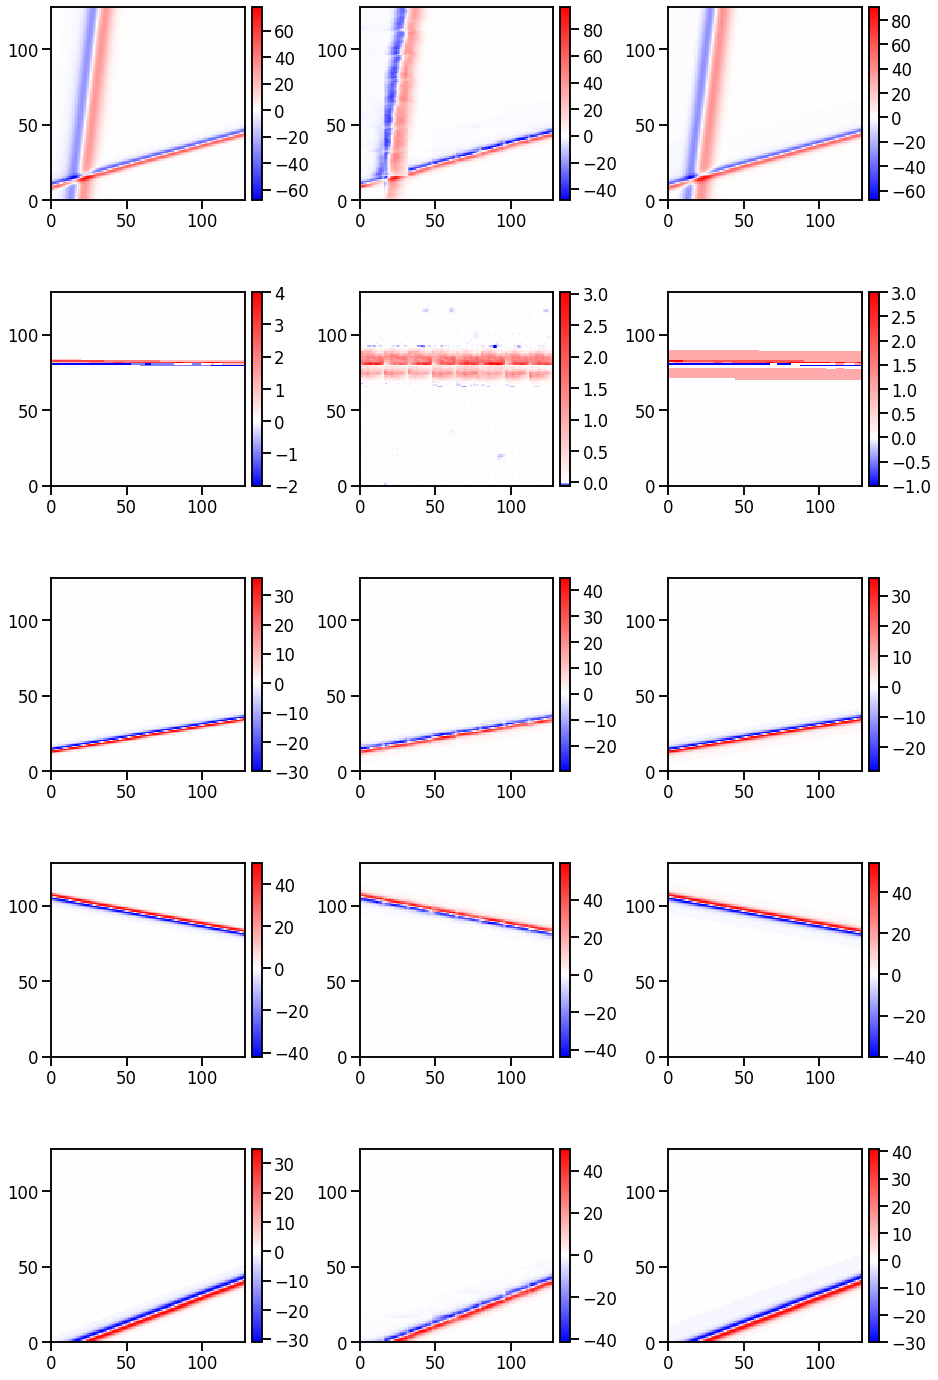

	valid loss:	0.371071
	Saving checkpoint
	peak memory use:	25.810G
Epoch 21 / 200
	lr:		0.001747 -> 0.001705
	time per epoch:	10.787215 seconds
	train loss:	0.389209
	valid loss:	0.411473
	peak memory use:	25.810G
Epoch 22 / 200
	lr:		0.001705 -> 0.001666
	time per epoch:	10.691862 seconds
	train loss:	0.353526
	valid loss:	0.342864
	peak memory use:	25.810G
Epoch 23 / 200
	lr:		0.001666 -> 0.001629
	time per epoch:	10.747574 seconds
	train loss:	0.350069
	valid loss:	0.367695
	peak memory use:	25.810G
Epoch 24 / 200
	lr:		0.001629 -> 0.001595
	time per epoch:	10.769535 seconds
	train loss:	0.352552
	valid loss:	0.325432
	peak memory use:	25.810G
Epoch 25 / 200
	lr:		0.001595 -> 0.001563
	time per epoch:	10.823868 seconds
	train loss:	0.341311
	valid loss:	0.341284
	peak memory use:	25.810G
Epoch 26 / 200
	lr:		0.001563 -> 0.001532
	time per epoch:	10.777700 seconds
	train loss:	0.330077
	valid loss:	0.319825
	peak memory use:	25.810G
Epoch 27 / 200
	lr:		0.001532 -> 0.001504
	time per

In [ ]:
# model = make_model(image_size, patch_size, N=3, d_model=256).to(device)
# num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f'number of parameters = {num_params/1024**2:.2f}M')

# model_opt = NoamOpt(
#     d_model,
#     1, # factor
#     20, # warmup
#     torch.optim.Adam(model.parameters(), lr=0, betas=(.9, .98), eps=1e-9)
# )

# epochs = 200
# for epoch in range(epochs):
#     print(f'Epoch {epoch + 1} / {epochs}')
#     # tells your model that you are training the model. 
#     # So effectively layers like dropout, batchnorm etc. 
#     # which behave different on the train and test procedures 
#     # know what is going on and hence can behave accordingly.
#     model.train()
#     start = time.time()
#     old_lr = get_lr(model_opt.optimizer)
#     loss_train = run_epoch(
#         loader_train,
#         model,
#         LossCompute(nn.L1Loss(), model_opt),
#         logging_freq=-1
#     )
#     new_lr = get_lr(model_opt.optimizer)
#     print(f'\tlr:\t\t{old_lr:.6f} -> {new_lr:.6f}')
#     print(f'\ttime per epoch:\t{time.time() - start:.6f} seconds')
#     print(f'\ttrain loss:\t{loss_train:.6f}')
    
#     # Validation:
#     if epoch % plot_freq == plot_freq - 1:
#         plot_func = SimplePlot
#     else:
#         plot_func = None
    
#     loss_valid = run_epoch(
#         loader_valid,
#         model,
#         LossCompute(nn.L1Loss()), # don't use an optimizer and the loss won't be back propagated
#         logging_freq=-1, 
#         plot_func=plot_func,
#         plot_kwargs={'num_samples': 3}
#     )
#     print(f'\tvalid loss:\t{loss_valid:.6f}')
    
#     if epoch % checkpoint_freq == checkpoint_freq - 1:
#         print('\tSaving checkpoint')
#         fname = f'model_dict_{epoch + 1}'
#         torch.save(model.state_dict(), f'{checkpoint_folder}/{fname}.pt')
#         torch.save(model.state_dict(), f'{checkpoint_folder}/model_dict_last.pt')
        
#     memory_cuda = torch.cuda.max_memory_allocated(device='cuda')
#     print(f'\tpeak memory use:\t{memory_cuda/1024 ** 3:.3f}G')

# Greedy Decoding

In [ ]:
def greedy_decode(model, x):
    memory = model.encode(src)
    y = 